In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

# import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log2
# from statistics import mean
# from scipy.special import kl_div
# from scipy.stats import norm
# from scipy import stats, special
from scipy.stats import fit, gamma, norm, exponnorm, laplace, gaussian_kde
# from statistics import NormalDist
# from statistics import NormalDist

import configuration as config
# import functions.data_manipulation as data_funcs
# import functions.plotting as plot_funcs

from IPython.display import Image
from IPython.core.display import HTML 

/mnt/arkk/llm_detector_benchmarking/benchmarking


# Perplexity ratio score: Kullback–Leibler divergence

Plan here is to take our sampling distributions of perplexity ratio scores for human and synthetic text and use them to generate a function that takes a perplexity ratio score and converts it into a Kullback-Leibler score. See the figure below from the [Wikipedia article on KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence).

In [2]:
Image(url = 'https://raw.githubusercontent.com/gperdrizet/llm_detector/benchmarking/benchmarking/notebooks/images/KL-Gauss-Example.png')

First, we will load up the perplexity score distributions and fit them. Then, calculate the KL divergence between the fitted distributions.

In [3]:
# Load the data
data_df = pd.read_json(f'{config.HANS_DATA_PATH}/pubmed-scores.json')

# Replace and remove string 'OOM' and 'NAN' values
data_df.replace('NAN', np.nan, inplace = True)
data_df.replace('OOM', np.nan, inplace = True)
data_df.dropna(inplace = True)

# Fix some d-types
data_df = data_df.astype({
    'Fragment length (tokens)': int, 
    'Perplexity': float,
    'Cross-perplexity': float,
    'Perplexity ratio score': float
})

data_df.head()

,Fragment,Fragment length (tokens),Dataset,Source,String,Reader peak memory (GB),Writer peak memory (GB),Perplexity,Cross-perplexity,Perplexity ratio score
0,0,173,pubmed-falcon7,human,my introduction to research occurred in the su...,8.087868,7.801447,2.925811,3.168792,0.923320
1,1,175,pubmed-falcon7,human,"which revolutionized work on proteins , was ju...",8.110666,7.818082,2.931023,2.905956,1.008626
2,2,71,pubmed-falcon7,human,"structural protein , a hydrophobic miniprotei...",6.845889,6.790534,3.388054,3.455927,0.980360
3,3,108,pubmed-falcon7,human,- known model that still dominates our thinkin...,7.266596,7.122000,2.992673,3.299628,0.906973
4,4,357,pubmed-falcon7,human,ions and other polar substances .\nthe fluidit...,10.595652,10.002441,2.815971,2.958800,0.951727


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51521 entries, 0 to 52920
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fragment                  51521 non-null  int64  
 1   Fragment length (tokens)  51521 non-null  int64  
 2   Dataset                   51521 non-null  object 
 3   Source                    51521 non-null  object 
 4   String                    51521 non-null  object 
 5   Reader peak memory (GB)   51521 non-null  float64
 6   Writer peak memory (GB)   51521 non-null  float64
 7   Perplexity                51521 non-null  float64
 8   Cross-perplexity          51521 non-null  float64
 9   Perplexity ratio score    51521 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 4.3+ MB


In [5]:
# Extract perplexity score ratios as lists, clipping outliers higher than 1.4
scores = data_df['Perplexity ratio score'][data_df['Perplexity ratio score'] < 1.4]
human_scores = data_df['Perplexity ratio score'][data_df['Source'] == 'human']
synthetic_scores = data_df['Perplexity ratio score'][data_df['Source'] == 'synthetic']

# Set up bins for the combined dataset
counts, bins = np.histogram(scores, bins = 100, density = True)

# Get bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Calculate histograms for the human and synthetic data
human_density, human_bins = np.histogram(human_scores, bins = bins, density = True)
synthetic_density, synthetic_bins = np.histogram(synthetic_scores, bins = bins, density = True)

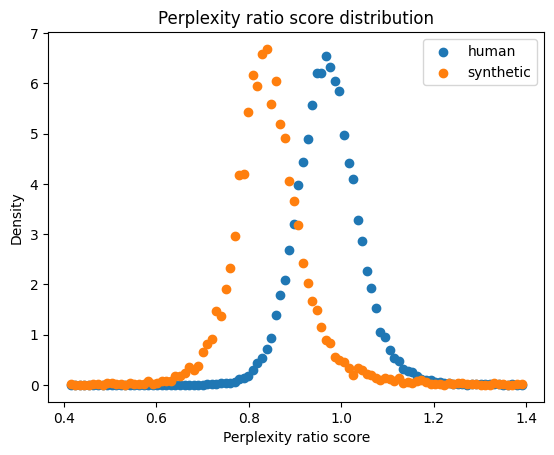

In [6]:
# Plot as scatter
plt.scatter(bin_centers, human_density, label = 'human')
plt.scatter(bin_centers, synthetic_density, label = 'synthetic')

plt.title('Perplexity ratio score distribution')
plt.xlabel('Perplexity ratio score')
plt.ylabel('Density')
plt.legend(loc = 'upper right')
plt.show()

Now, try fitting a couple of different continuous distributions to see what looks good.

In [7]:
# Gaussian distribution
bounds = [[0.6,1.2],[0,10]]

human_norm = fit(norm, human_scores, bounds = bounds)
human_norm_fit = norm(human_norm.params.loc, human_norm.params.scale).pdf(bin_centers)

synthetic_norm = fit(norm, synthetic_scores, bounds = bounds)
synthetic_norm_fit = norm(synthetic_norm.params.loc, synthetic_norm.params.scale).pdf(bin_centers)

/mnt/arkk/llm_detector_benchmarking/.venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1636: RuntimeWarning: overflow encountered in divide
  x = asarray((x-loc) / scale)


In [8]:
# Exponential Gaussian
bounds = [[0,10],[0.6,1.2],[0,10]]

human_exponnorm = fit(exponnorm, human_scores, bounds = bounds)
human_exponnorm_fit = exponnorm(human_exponnorm.params.K, human_exponnorm.params.loc, human_exponnorm.params.scale).pdf(bin_centers)

synthetic_exponnorm = fit(exponnorm, synthetic_scores, bounds = bounds)
synthetic_exponnorm_fit = exponnorm(synthetic_exponnorm.params.K, synthetic_exponnorm.params.loc, synthetic_exponnorm.params.scale).pdf(bin_centers)

/mnt/arkk/llm_detector_benchmarking/.venv/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:1782: RuntimeWarning: overflow encountered in scalar divide
  invK = 1.0 / K


In [9]:
# Gamma distribution
bounds = [[1,100],[0,1],[0,1]]

human_gamma = fit(gamma, human_scores, bounds = bounds)
human_gamma_fit = gamma(human_gamma.params.a, human_gamma.params.loc, human_gamma.params.scale).pdf(bin_centers)

synthetic_gamma = fit(gamma, synthetic_scores, bounds = bounds)
synthetic_gamma_fit = gamma(synthetic_gamma.params.a, synthetic_gamma.params.loc, synthetic_gamma.params.scale).pdf(bin_centers)

In [10]:
# Laplace
bounds = [[0,10],[0,10]]

human_laplace = fit(laplace, human_scores, bounds = bounds)
human_laplace_fit = laplace(human_laplace.params.loc, human_laplace.params.scale).pdf(bin_centers)

synthetic_laplace = fit(laplace, synthetic_scores, bounds = bounds)
synthetic_laplace_fit = laplace(synthetic_laplace.params.loc, synthetic_laplace.params.scale).pdf(bin_centers)

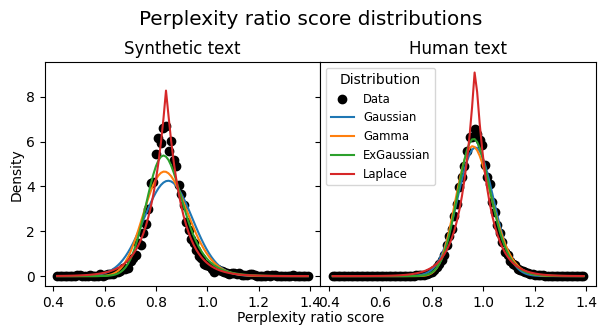

In [11]:
fig, axs=plt.subplots(
    1,
    2,
    figsize=(6, 3),
    sharex='col',
    sharey='row',
    tight_layout=True,
    gridspec_kw = {'wspace':0, 'hspace':0}
)

axs[0].set_title('Synthetic text')
axs[0].scatter(bin_centers, synthetic_density, color = 'black', label = 'Data')
axs[0].plot(bin_centers, synthetic_norm_fit, label = 'Gaussian')
axs[0].plot(bin_centers, synthetic_gamma_fit, label = 'Gamma')
axs[0].plot(bin_centers, synthetic_exponnorm_fit, label = 'ExGaussian')
axs[0].plot(bin_centers, synthetic_laplace_fit, label = 'Laplace')

axs[1].set_title('Human text')
axs[1].scatter(bin_centers, human_density, color = 'black', label = 'Data')
axs[1].plot(bin_centers, human_norm_fit, label = 'Gaussian')
axs[1].plot(bin_centers, human_gamma_fit, label = 'Gamma')
axs[1].plot(bin_centers, human_exponnorm_fit, label = 'ExGaussian')
axs[1].plot(bin_centers, human_laplace_fit, label = 'Laplace')

axs[1].legend(
    title = 'Distribution',
    loc = 'upper left',
    fontsize = 'small'
)

# Set figure title
fig.text(0.5, 1, 'Perplexity ratio score distributions', ha='center', fontsize='x-large')

# Set single label for shared x
fig.text(0.5, 0.01, 'Perplexity ratio score', ha='center')

# Set single label for shared y
fig.text(0.01, 0.5, 'Density', va='center', ha='center', rotation=90)

plt.show()

Laplassian is too sharp, Gaussian too blunt, especialy on the synthetic text distribution, think the exponential Gaussian has it.

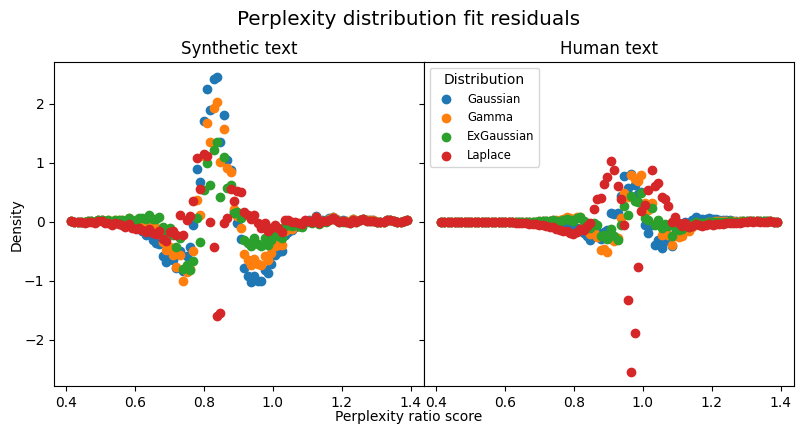

In [12]:
fig, axs=plt.subplots(
    1,
    2,
    figsize=(8, 4),
    sharex='col',
    sharey='row',
    tight_layout=True,
    gridspec_kw = {'wspace':0, 'hspace':0}
)

axs[0].set_title('Synthetic text')
axs[0].scatter(bin_centers, (synthetic_density - synthetic_norm_fit), label = 'Gaussian')
axs[0].scatter(bin_centers, (synthetic_density - synthetic_gamma_fit), label = 'Gamma')
axs[0].scatter(bin_centers, (synthetic_density - synthetic_exponnorm_fit), label = 'ExGaussian')
axs[0].scatter(bin_centers, (synthetic_density - synthetic_laplace_fit), label = 'Laplace')

axs[1].set_title('Human text')
axs[1].scatter(bin_centers, (human_density - human_norm_fit), label = 'Gaussian')
axs[1].scatter(bin_centers, (human_density - human_gamma_fit), label = 'Gamma')
axs[1].scatter(bin_centers, (human_density - human_exponnorm_fit), label = 'ExGaussian')
axs[1].scatter(bin_centers, (human_density - human_laplace_fit), label = 'Laplace')

axs[1].legend(
    title = 'Distribution',
    loc = 'upper left',
    fontsize = 'small'
)

# Set figure title
fig.text(0.5, 1, 'Perplexity distribution fit residuals', ha='center', fontsize='x-large')

# Set single label for shared x
fig.text(0.5, 0.01, 'Perplexity ratio score', ha='center')

# Set single label for shared y
fig.text(0.01, 0.5, 'Density', va='center', ha='center', rotation=90)

plt.show()

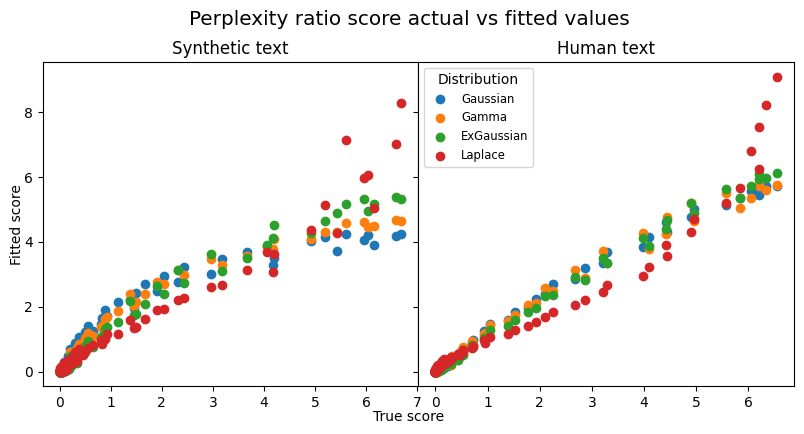

In [13]:
fig, axs=plt.subplots(
    1,
    2,
    figsize=(8, 4),
    sharex='col',
    sharey='row',
    tight_layout=True,
    gridspec_kw = {'wspace':0, 'hspace':0}
)

axs[0].set_title('Synthetic text')
axs[0].scatter(synthetic_density, synthetic_norm_fit, label = 'Gaussian')
axs[0].scatter(synthetic_density, synthetic_gamma_fit, label = 'Gamma')
axs[0].scatter(synthetic_density, synthetic_exponnorm_fit, label = 'ExGaussian')
axs[0].scatter(synthetic_density, synthetic_laplace_fit, label = 'Laplace')

axs[1].set_title('Human text')
axs[1].scatter(human_density, human_norm_fit, label = 'Gaussian')
axs[1].scatter(human_density, human_gamma_fit, label = 'Gamma')
axs[1].scatter(human_density, human_exponnorm_fit, label = 'ExGaussian')
axs[1].scatter(human_density, human_laplace_fit, label = 'Laplace')

axs[1].legend(
    title = 'Distribution',
    loc = 'upper left',
    fontsize = 'small'
)

# Set figure title
fig.text(0.5, 1, 'Perplexity ratio score actual vs fitted values', ha='center', fontsize='x-large')

# Set single label for shared x
fig.text(0.5, 0.01, 'True score', ha='center')

# Set single label for shared y
fig.text(0.01, 0.5, 'Fitted score', va='center', ha='center', rotation=90)

plt.show()

In [14]:
def kl_divergence(p, q):
    '''Takes two lists, calcualtes KD divergence'''
    return [p[i] * log2(p[i]/q[i]) for i in range(len(p))]

/tmp/ipykernel_3040232/2194145356.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  return [p[i] * log2(p[i]/q[i]) for i in range(len(p))]


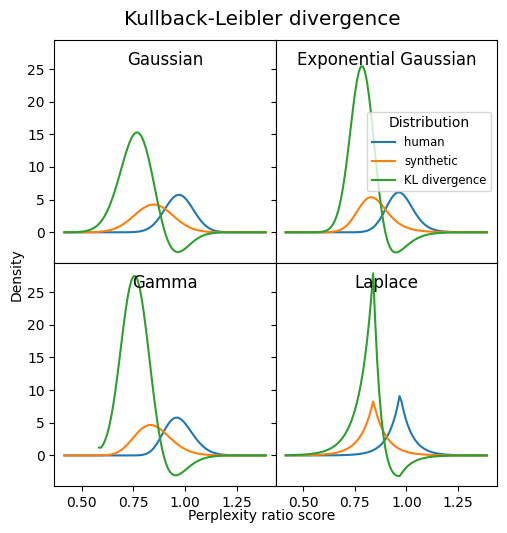

In [15]:
fig, axs=plt.subplots(
    2,
    2,
    figsize=(5, 5),
    sharex=True,
    sharey=True,
    tight_layout=True,
    gridspec_kw = {'wspace':0, 'hspace':0}
)

axs[0,0].set_title('Gaussian', y=1.0, pad=-18)
axs[0,0].plot(bin_centers, human_norm_fit, label = 'human')
axs[0,0].plot(bin_centers, synthetic_norm_fit, label = 'synthetic')
axs[0,0].plot(bin_centers, kl_divergence(synthetic_norm_fit, human_norm_fit), label = 'KL divergence')

axs[0,1].set_title('Exponential Gaussian', y=1.0, pad=-18)
axs[0,1].plot(bin_centers, human_exponnorm_fit, label = 'human')
axs[0,1].plot(bin_centers, synthetic_exponnorm_fit, label = 'synthetic')
axs[0,1].plot(bin_centers, kl_divergence(synthetic_exponnorm_fit, human_exponnorm_fit), label = 'KL divergence')

axs[1,0].set_title('Gamma', y=1.0, pad=-18)
axs[1,0].plot(bin_centers, human_gamma_fit, label = 'human')
axs[1,0].plot(bin_centers, synthetic_gamma_fit, label = 'synthetic')
axs[1,0].plot(bin_centers, kl_divergence(synthetic_gamma_fit, human_gamma_fit), label = 'KL divergence')

axs[1,1].set_title('Laplace', y=1.0, pad=-18)
axs[1,1].plot(bin_centers, human_laplace_fit, label = 'human')
axs[1,1].plot(bin_centers, synthetic_laplace_fit, label = 'synthetic')
axs[1,1].plot(bin_centers, kl_divergence(synthetic_laplace_fit, human_laplace_fit), label = 'KL divergence')


axs[0,1].legend(
    title = 'Distribution',
    loc = 'center right',
    fontsize = 'small'
)

# Set figure title
fig.text(0.5, 1, 'Kullback-Leibler divergence', ha='center', fontsize='x-large')

# Set single label for shared x
fig.text(0.5, 0.01, 'Perplexity ratio score', ha='center')

# Set single label for shared y
fig.text(0.01, 0.5, 'Density', va='center', ha='center', rotation=90)

plt.show()

Again, the exponential gaussian looks best, I think. Proof will be in the pudding, but before we move on, I want to try this one more way. Let's see if we can use kernel density extimates of the perplexity ratio score distributions to get the KL divirgence. That way we don't even have to worry about fitting the data or justifying the choice of distribution.

In [16]:
# Get kernel density estimates for the score distributions
human_kde = gaussian_kde(human_scores)
synthetic_kde = gaussian_kde(synthetic_scores)

# Calculate the KL divergence
kl = kl_divergence(synthetic_kde.pdf(bin_centers), human_kde.pdf(bin_centers))

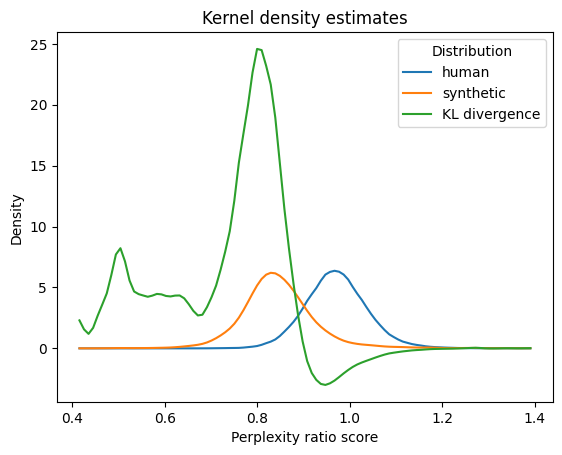

In [17]:
plt.title('Kernel density estimates')
plt.plot(bin_centers, human_kde.pdf(bin_centers), label = 'human')
plt.plot(bin_centers, synthetic_kde.pdf(bin_centers), label = 'synthetic')
plt.plot(bin_centers, kl, label = 'KL divergence')
plt.xlabel('Perplexity ratio score')
plt.ylabel('Density')
plt.legend(
    title = 'Distribution',
    loc = 'upper right'
)

plt.show()

Still think the Gaussian or the exponential gaussian looks better, but It's nice to have a non-parametric way to do this. I think we should declare victory and move on. Next thing to work on is setting building the training data for XGBoost.